### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from logger import logger
from utils import si_format
from wfutils import *

### Input parameters

In [28]:
# Waveform parameters
Fdrive = 2.1e6  # carrier frequency (Hz)
P = 0.8  # pressure amplitude (MPa)
tstim = 200e-3  # burst duration (s)
PRF = 100.  # burst internal PRF (Hz)
npts = 100  # nominal waveform envelope vector size
npulses = 5  # number of pulses in the burst
DCvec = np.linspace(5, 100, 20)  # burst internal duty cycles (%)

# Spectrum extraction settings
norm = False  #True  # whether to normalize computed spectra to their maximum value
dB = True  # whether to convert computed spectra to dB units

# Plot settings
plot_wfs = Fdrive / PRF < 1e3  # determine if we need to plot waveforms
if DCvec.size > 5:
    iplt = np.linspace(0, DCvec.size - 1, 5).astype(int)
else:
    iplt = np.arange(DCvec.size)
fcolors = {'carrier': 'k', 'PRF': 'r'}

 2024/04/08 11:04:45: looping through duty cycles and generating waveforms
 2024/04/08 11:04:45: generating waveform for DC = 5% (PD = 0.50 ms)


 2024/04/08 11:04:46: generating waveform for DC = 10% (PD = 1.00 ms)
 2024/04/08 11:04:46: generating waveform for DC = 15% (PD = 1.50 ms)
 2024/04/08 11:04:46: generating waveform for DC = 20% (PD = 2.00 ms)
 2024/04/08 11:04:46: generating waveform for DC = 25% (PD = 2.50 ms)
 2024/04/08 11:04:46: generating waveform for DC = 30% (PD = 3.00 ms)
 2024/04/08 11:04:46: generating waveform for DC = 35% (PD = 3.50 ms)
 2024/04/08 11:04:47: generating waveform for DC = 40% (PD = 4.00 ms)
 2024/04/08 11:04:47: generating waveform for DC = 45% (PD = 4.50 ms)
 2024/04/08 11:04:47: generating waveform for DC = 50% (PD = 5.00 ms)
 2024/04/08 11:04:47: generating waveform for DC = 55% (PD = 5.50 ms)
 2024/04/08 11:04:47: generating waveform for DC = 60% (PD = 6.00 ms)
 2024/04/08 11:04:47: generating waveform for DC = 65% (PD = 6.50 ms)
 2024/04/08 11:04:47: generating waveform for DC = 70% (PD = 7.00 ms)
 2024/04/08 11:04:48: generating waveform for DC = 75% (PD = 7.50 ms)
 2024/04/08 11:04:48

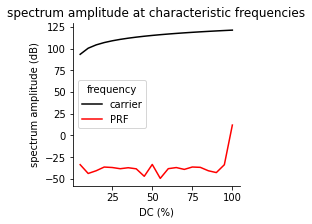

In [29]:
# Create figure if plotting waveforms flag is set
if plot_wfs:
    fig, axes = plt.subplots(len(iplt), 2, figsize=(8, 2 * len(iplt)), sharex='col', sharey='col')
else:
    axes = [None] * len(DCvec)

# Define empty dataframe for storing spectrum values at carrier and PRF
spectrum_values = pd.DataFrame(
    index=pd.Index(DCvec, name='DC (%)'),
    columns=pd.Index(fcolors.keys(), name='frequency')
)

# Loop over DC vector
logger.info('looping through duty cycles and generating waveforms')
irow = 0
for i, DC in enumerate(DCvec):
    # Generate label
    label = f'DC = {DC:.0f}%'

    # Compute pulse duration
    PD = (DC * 1e-2) / PRF  # s
    toffset = 1 / PRF - PD  # s

    # Generate envelope and waveform
    logger.info(f'generating waveform for {label} (PD = {PD * 1e3:.2f} ms)')
    tenv, yenv = get_pulse_envelope(npts, PD, toffset=toffset, nreps=npulses)
    tdense, ydense, yenvdense = get_full_waveform(tenv, yenv, Fdrive)

    # Plot waveform trace and spectrum, if specified
    if plot_wfs and i in iplt:
        logger.info(f'plotting waveform trace and spectrum for {label}')
        axrow = axes[irow]
        irow += 1
        plot_waveform_trace(tenv, yenv, Fdrive, ax=axrow[0])
        plot_waveform_spectrum(tdense, ydense, label=label, ax=axrow[1], norm=norm, dB=dB)

    # Compute dB power spectrum
    freqs, ps = get_power_spectrum(tdense, ydense, norm=norm, dB=dB)

    # Extract power spectrum values at carrier freq and PRF
    spectrum_values.loc[DC, 'carrier'] = np.interp(Fdrive, freqs, ps)
    spectrum_values.loc[DC, 'PRF'] = np.interp(PRF, freqs, ps)

if plot_wfs:
    # Add vertical lines for carrier and PRF on spectrum plots
    for ax in axes[:, 1]:
        for fname, fval in {'carrier': Fdrive, 'PRF': PRF}.items():
            ax.axvline(
                fval, ls='--', lw=1, label=f'{fname} = {si_format(fval)}Hz', c=fcolors[fname])
        ax.legend()
        sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)

    # Adjust figure layout and render
    fig.tight_layout()

sname = 'spectrum amplitude'
if norm:
    snane = f'normalized {sname}'
if dB:
    sname = f'{sname} (dB)'
spectrum_values = spectrum_values.stack().rename(sname)

# Plot log-spectrum value at carrier and PRF as a function of DC
fig, ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
ax.set_title(f'spectrum amplitude at characteristic frequencies')
sns.lineplot(
    ax=ax,
    data=spectrum_values.reset_index(),
    x='DC (%)',
    y=sname,
    hue='frequency',
    palette=fcolors,
);